In [11]:
import math
import pandas as pd
from numpy import *
import matplotlib.pyplot as plt 

from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import utils

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import datetime

import os, time

import numpy as np
import matplotlib.pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision

import pandas as pd
import torch


# The microstructure effect 


One of the first aspects that one must master to trade an asset is the effect of the microstructure.
Market microstructure refers to all of its aspects related to choices and
individual decisions of agents as well as the discretization of market prices.
In order to measure the time scale from which the microstructure is felt, we
we tried to estimate the signature plot and to quantify the effect of Epps from data at the
minute.

Let's start with the signature plot. Recall that this is a graph representing the volatility
estimate of the course based on the time increment chosen in the estimate formula.
Without the market microstructure, the estimated volatility should converge to a finite value. This
this is not the case if we take into account the microstructure. Indeed, we then have price jumps of
discontinuous manner which causes the divergence of this curve. 



# Data importation

In [21]:
btcusd_minute = pd.read_csv("datas/gemini_BTCUSD_2019_1min.csv")
ethusd_minute = pd.read_csv("datas/gemini_ETHUSD_2019_1min.csv")
ltcusd_minute = pd.read_csv("datas/gemini_LTCUSD_2019_1min.csv")
zecusd_minute = pd.read_csv("datas/gemini_ZECUSD_2019_1min.csv")



In [22]:
list_datas = [btcusd_minute, ethusd_minute, ltcusd_minute, zecusd_minute]
list_names = ["BTC", "ETH", "LTC", "ZEC"]
n_cryptos = 4

In [23]:
for i in range(n_cryptos):
    list_datas[i] = list_datas[i].iloc[::-1].set_index([pd.Index([i for i in range(len(list_datas[i]))])])

# Adding new column of succesives returns

In [24]:
for i in range(n_cryptos):
    list_datas[i]["move"] = (list_datas[i]["Close"] / list_datas[i]["Open"] - 1)* 100

# Realized volatility estimator

$$
\sigma = \sqrt{\frac{365}{N}\sum_{i=1}^{N} \log (\frac{S_{t_{i}}}{S_{t_{i-1}}})^2}
$$

In [25]:
def get_vols(datas, list_steps):
    list_estimations = []
    n = len(datas)
    for step in list_steps:
        N = n // step
        S = 0
        for i in range(N):
            c = datas["Open"][i*step] / datas["Close"][(i+1)*step - 1]
            S = S + log(c)**2
        list_estimations.append(math.sqrt(365*1440/step*S/N))
    return list_estimations

In [26]:
list_steps = [2**i for i in range(0,15)]
vols = []
for datas in list_datas:
    vols.append(get_vols(datas, list_steps))

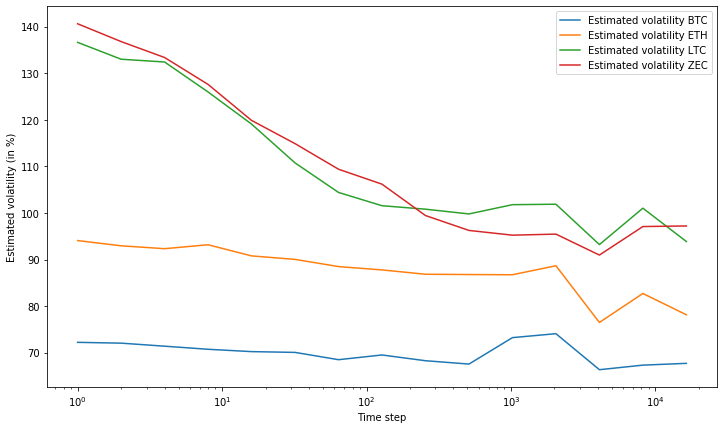

In [27]:
fig = plt.figure(figsize=(12,7))

for i in range(n_cryptos):
    plt.plot(list_steps, np.array(vols[i])*100, label='Estimated volatility ' +list_names[i])
    
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Estimated volatility (in %)")
plt.gca().set_xscale("log")
plt.savefig("microstructure_1min.png")


Plot signature for the 4 crypto studied for time step > 1 min

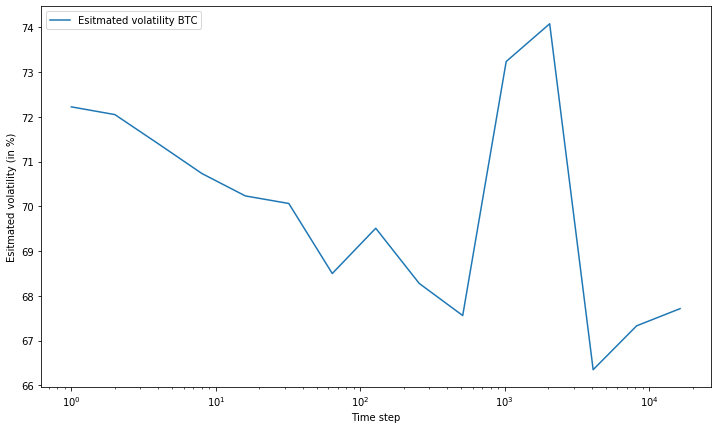

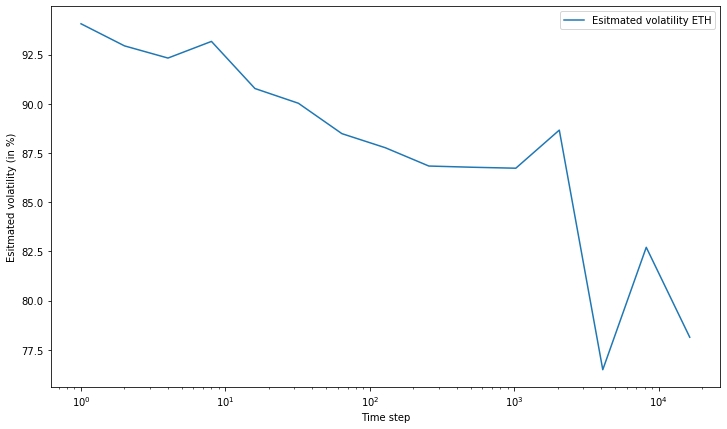

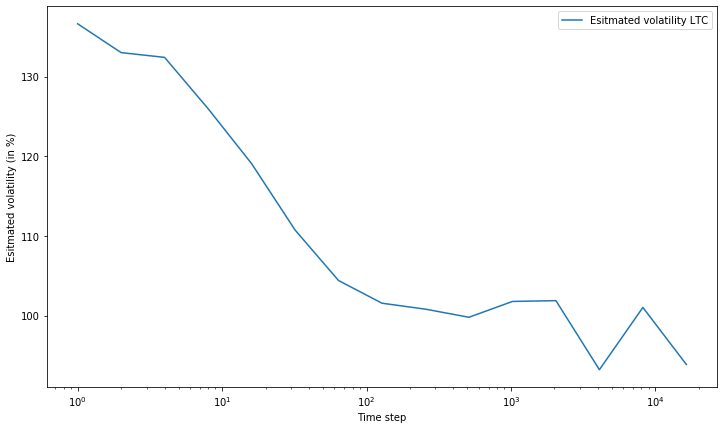

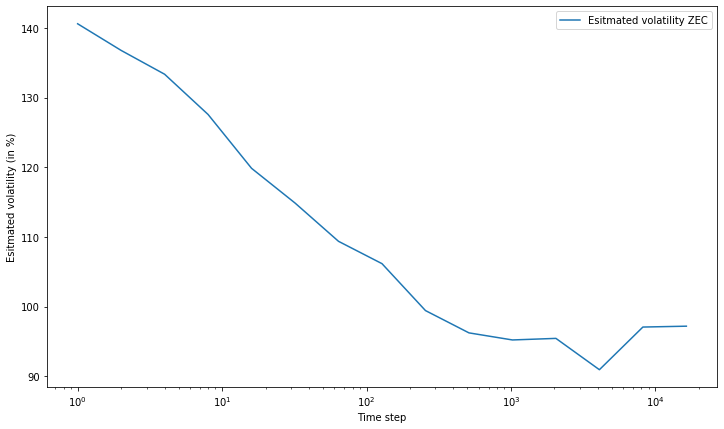

In [28]:
for i in range(n_cryptos):
    fig = plt.figure(figsize=(12,7))

    plt.plot(list_steps, np.array(vols[i])*100, label='Esitmated volatility ' +list_names[i])
    
    plt.legend()
    plt.xlabel("Time step")
    plt.ylabel("Esitmated volatility (in %)")
    plt.gca().set_xscale("log")
#plt.savefig("save_fig/fig_" + name+".png")

This graph is remarkable because we observe two distinct behaviors. First of all, we
notes that the estimated volatilities of bitcoin and ether prices are relatively stable.
This means that these markets are extremely liquid and the effect of the microstructure is little
feel beyond the minute.
Conversely, we notice that with time steps less than 1 or 2 hours, the effect of
microstructure is felt on the prices of Litecoin and Zcash. 
The effect of the microstructure is much more persistent: these markets are
less liquid.
We wanted to focus on data below the minute. 
By resuming the study previous but by going to the microsecond scale rather than the minute, we get the
results presented in graph 6. In this case, we see that the curves start to diverge
(in fact, to be affine) from time steps between 10 seconds and one minute.


# EPPS effect 

Now let's move on to the Epps effect. It illustrates the same problem in a different way.
Now it is a question of estimating the correlation between two assets. For this, we use the formula
next:



$$
\rho =  \frac{1}{T \sigma_{X} \sigma_{Y}} \sum_{i=1}^{N} (X_{t_{i}} - X_{t_{i-1}})(Y_{t_{i}} - Y_{t_{i-1}})
$$


The consequence of the microstructure on the estimate of the correlation is the reverse of that on
the estimate of volatility. The Epps effect indeed states that the estimator will converge to 0
because the jumps of the two considered assets do not take place at the same time. The Epps effect is good
visible in the figures below and it is present for time steps of about 1 minute.

Before entering these markets, it is important to have a good grasp of the various aspects of
microstructure. In particular, consistent estimators of volatility and correlation
exist to take into account the effects of microstructure, such as the estimator
by Hayashi-Yoshida. These estimators are particularly useful if one wishes to engage in
algorithmic trading, especially in high frequency.




# Data import 

In [35]:
btcusd_daily = pd.read_csv("datas/Gemini_BTCUSD_d.csv")
ethusd_daily = pd.read_csv("datas/Gemini_ETHUSD_d.csv")
ltcusd_daily = pd.read_csv("datas/Gemini_LTCUSD_d.csv")
zecusd_daily = pd.read_csv("datas/gemini_ZECUSD_day.csv")

list_datas = [btcusd_daily, ethusd_daily, ltcusd_daily, zecusd_daily]
list_names = ["BTC", "ETH", "LTC", "ZEC"]
n_cryptos = 4

In [36]:
for i in range(n_cryptos):
    list_datas[i] = list_datas[i].iloc[::-1].set_index([pd.Index([i for i in range(len(list_datas[i]))])])

In [37]:
list_datas[3] = list_datas[3].iloc[30:].set_index([pd.Index([i for i in range(len(list_datas[3])-30)])])

In [38]:
for i in range(n_cryptos):
    list_datas[i]["move100"] = (list_datas[i]["Close"] / list_datas[i]["Open"] - 1)* 100
    list_datas[i]["log_move"] = np.log(list_datas[i]["Close"] / list_datas[i]["Open"])

# General autocorellation function 

In [39]:
def autocorrelation(datas, f, g, begin=-20, end=100, step=1, h_normalization=None):
    n_datas = len(datas)
    list_times = []
    list_correls = []
    
    fx = datas.apply(f)
    gx = datas.apply(g)
    mfx = np.mean(fx)
    mfy = np.mean(gx)
    if(h_normalization == None ):
        normalization = math.sqrt(np.var(fx) * np.var(gx))
    else:
        normalization=h_normalization(datas)
    
    for tau in range(begin, end+1, step):
        tau_begin = max(0, -tau)
        tau_end = min(n_datas, n_datas-tau)
        tau_n = tau_end - tau_begin

        c = 0
        for i in range(tau_begin, tau_end):
            c = c + fx[i] * gx[i+tau]

        c = (c/tau_n - mfx*mfy) / (normalization)
        
        list_times.append(tau)
        list_correls.append(c)
    
    return list_times, list_correls

# Returns autocorellation 

It is well known that the returns are not meant to be autocorrelated. This is mainly explained
by the assumption of no arbitrage opportunity. We can easily verify
this in the cryptocurrency market.

However, absolute values or squares of returns are meant to be. This can be explained
because using formula 1 with T = 1 and t = 1 day = 1
365 and N = 1, we see that the instantaneous volatility process can approach the absolute value of returns. Volatility is
often assumed to be continuous and does not vary much from day to day, which explains this
autocorrelation.It can be seen that it decreases slowly.



In [40]:
def autocorrelation_rendements(datas, begin=-20, end=100, step=1):
    identity = lambda x: x
    return  autocorrelation(datas, identity, identity, begin=begin, end=end, step=step)

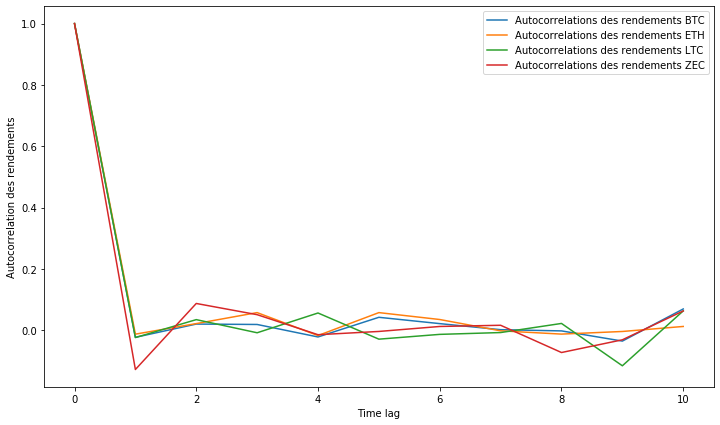

In [41]:
fig = plt.figure(figsize=(12,7))

for i in range(n_cryptos):
    list_times, list_correls = autocorrelation_rendements(list_datas[i].log_move,begin=0, end=10)
    plt.plot(list_times, list_correls, label='Autocorrelations des rendements ' +list_names[i])

plt.legend()
plt.xlabel("Time lag")
plt.ylabel("Autocorrelation des rendements")
#plt.gca().set_xscale("log")
plt.savefig("autocorrelation_rendements.png")

In [42]:
def autocorrelation_absolute_rendements(datas, begin=-20, end=100, step=1):
    absolute_value = lambda x: abs(x)
    return  autocorrelation(datas, absolute_value, absolute_value, begin=begin, end=end, step=step)

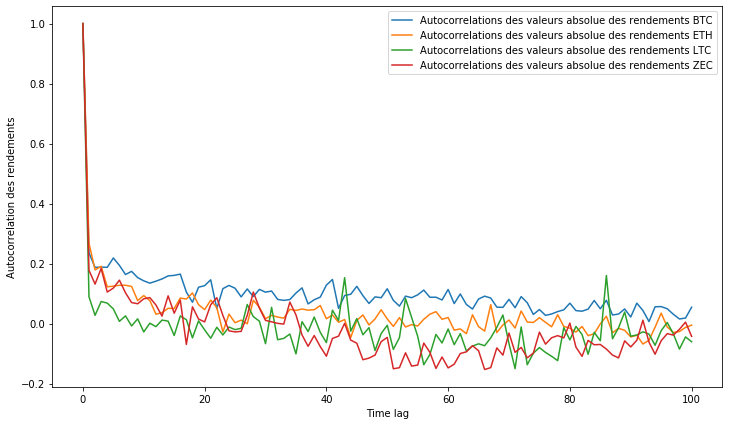

In [43]:
fig = plt.figure(figsize=(12,7))

for i in range(n_cryptos):
    list_times, list_correls = autocorrelation_absolute_rendements(list_datas[i].log_move,begin=0, end=100)
    plt.plot(list_times, list_correls, label='Autocorrelations des valeurs absolue des rendements ' +list_names[i])

plt.legend()
plt.xlabel("Time lag")
plt.ylabel("Autocorrelation des rendements")
#plt.gca().set_xscale("log")
plt.savefig("autocorrelation_absolute_rendements.png")

In [44]:
def autocorrelation_volatility2(datas, begin=-20, end=100, step=1):
    square = lambda x: x*x
    return  autocorrelation(datas, square, square, begin=begin, end=end, step=step)

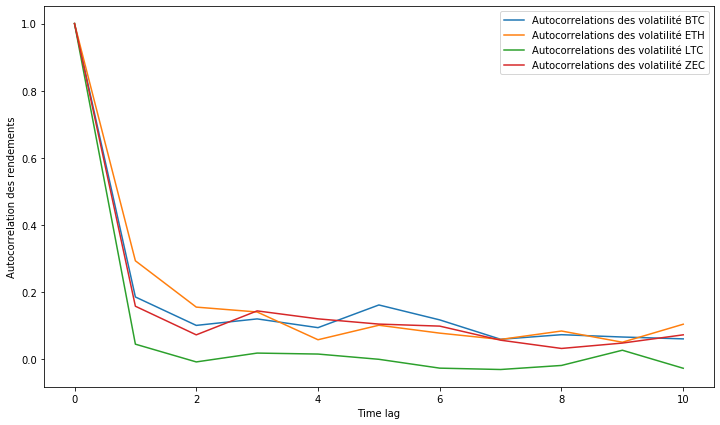

In [45]:
fig = plt.figure(figsize=(12,7))

for i in range(n_cryptos):
    list_times, list_correls = autocorrelation_volatility2(list_datas[i].log_move,begin=0, end=10)
    plt.plot(list_times, list_correls, label='Autocorrelations des volatilité ' +list_names[i])

plt.legend()
plt.xlabel("Time lag")
plt.ylabel("Autocorrelation des rendements")
#plt.gca().set_xscale("log")
plt.savefig("autocorrelation_volatility2.png")

# Leverage effect

We can also measure the leverage effect which corresponds to a negative correlation between past returns and future volatility
This effect is particularly important for option markets: not only does it imply that at-the-money volatilities tend to increase after price drops, but also that a significant skew in the volatility smile should
appear, as is indeed observed on markets where the leverage effect is strong

It is defined by :
    
$$
L(\tau ) = \frac{ \sum_{t}\Delta X(t) (\Delta X(t + \tau))^2}{\sum_{t}(\Delta X(t))^{4}}
$$



In [46]:
def leverage_effect(datas, begin=-20, end=100, step=1):
    identity = lambda x: x
    square = lambda x: x*x
    normalization = lambda dt: np.mean(dt.apply(square))**2
    return  autocorrelation(datas, identity, square, begin=begin, end=end, step=step, h_normalization=normalization)

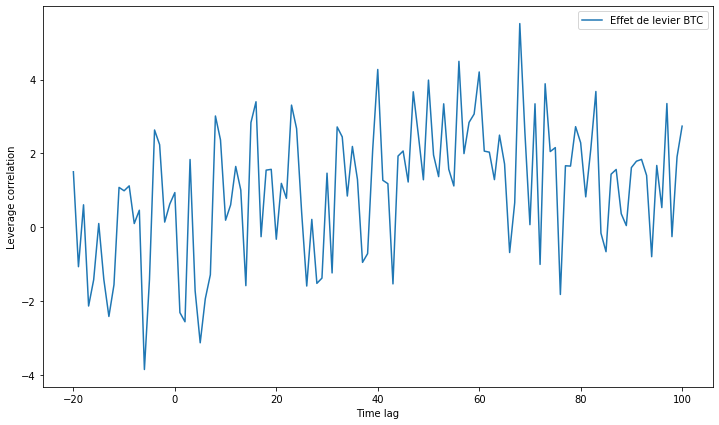

In [47]:
fig = plt.figure(figsize=(12,7))

for i in range(1):
    list_times, list_correls = leverage_effect(list_datas[i].log_move,begin=-20, end=100)
    plt.plot(list_times, list_correls, label='Effet de levier ' +list_names[i])

plt.legend()
plt.xlabel("Time lag")
plt.ylabel("Leverage correlation")
#plt.gca().set_xscale("log")
plt.savefig("leverage_effect.png")

Given the shape of this curve, we can assume that the stationary regime is not
still reached, or when we do not have enough data to conclude.